In [3]:
# Import the needed pacakges
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab 
from pylab import xticks
import seaborn as sns
import statistics
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
%matplotlib inline

In [4]:
import boto3, re, sys, math, json, os, sagemaker, urllib.request
import io
import sagemaker
from pyathena import connect
from prettytable import PrettyTable 
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, \
RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, mean_squared_error,\
precision_score, recall_score, f1_score, accuracy_score,\
confusion_matrix, plot_confusion_matrix, classification_report
from sagemaker.tuner import HyperparameterTuner
from sklearn.linear_model import LogisticRegression
from scipy.stats import loguniform
import warnings
warnings.filterwarnings('ignore')

In [5]:
import csv

In [6]:
df_TVA = pd.read_csv(
    "s3://goldendrive/Traffic_Volumes_AADT.csv"
)
df_TVA.shape

(7114, 15)

In [22]:
HOV = pd.read_csv(
    "s3://goldendrive/HOV.csv"
)
HOV.shape

(109, 17)

In [8]:
df_HOV.head()

,OBJECTID,District,Route,Direction,Begin_County,Begin_Post_Mile,End_County,End_Post_Mile,Begin_Abs_Post_Mile,End_Abs_Post_Mile,Description,Length__Lane_Miles_,Occupancy_Requirement,Hours_of_Operation,Segment_Opening_Date,Comments,Shape_Length
0,1,3,50,EB,SAC,R5.371,ED,5.834,11.005,34.632,Watt Ave to Cameron Park Dr,23.627,2+,M-F 06:00-10:00 and 15:00-19:00,Watt Ave to Sunrise Blvd - Dec 2011; Sunrise B...,NaN,48659.155980
1,2,3,80,EB,SAC,M0.767,PLA,4.718,84.691,106.237,West El Camino Ave to SR-65,21.546,2+,M-F 06:00-10:00 and 15:00-19:00,Yolo Co Line to Longview Dr - Dec 2016; Longvi...,NaN,44432.185806
2,3,4,80,EB,SOL,0.504,SOL,0.673,27.995,28.164,Carquinez Bridge Toll Plaza,0.255,3+,M-F 05:00-10:00 and 15:00-19:00,"Opened; W/O Toll Plaza to E/O Toll Plaza, 07/3...",2-Seat Vehicles with 2 Persons Permitted; Toll...,348.131415
3,4,4,80,EB,SOL,R11.485,SOL,19.594,38.976,47.096,Red Top Road to Air Base Pkwy,8.120,2+,M-F 05:00-10:00 and 15:00-19:00,"Opened; Red Top Road to E/O Air Base Pkwy., 11...",NaN,16660.846138
4,5,7,10,EB,LA,30.995,LA,48.265,29.495,46.765,I-605 to San Bernardino County Line,17.270,2+,24 Hr,Rte 605 to 0.6 mi west of Puente Ave (Francisq...,Continues into San Bernardino County,33527.727027


In [16]:
df_traveltime = pd.read_csv(
    "s3://goldendrive/pems_output.csv"
)
df_traveltime.shape

(10080, 5)

In [17]:
df_traveltime.head()

,5 Minutes,Mainline Agg,HOV/HOT Agg,# Lane Pts,% Observed
0,10/1/2009 0:00,32.63,30.95,265.0,51.7
1,10/1/2009 0:05,32.83,31.07,267.0,52.4
2,10/1/2009 0:10,33.17,31.22,266.0,51.9
3,10/1/2009 0:15,33.35,31.22,267.0,52.1
4,10/1/2009 0:20,33.15,31.17,266.0,52.3


In [11]:
# create athena database
session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
bucket = session.default_bucket()

s3 = boto3.Session().client(service_name="s3", region_name=region)

In [12]:
ingest_create_athena_db_passed = False

# set a database name
database_name = "goldendrive"

In [13]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [14]:
# set up PyAthena connection
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [20]:
# The SQL statement to execute
sql_statement="""
SELECT DISTINCT product_category from {0}.{1}
ORDER BY product_category
""".format("goldendrive", df_traveltime)

In [ ]:
#pd.read_sql(sql_statement, conn)

In [15]:
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement)
pd.read_sql(statement, conn)

CREATE DATABASE IF NOT EXISTS goldendrive


""


In [ ]:
#golden_dir = 's3://goldendrive/raw_files'

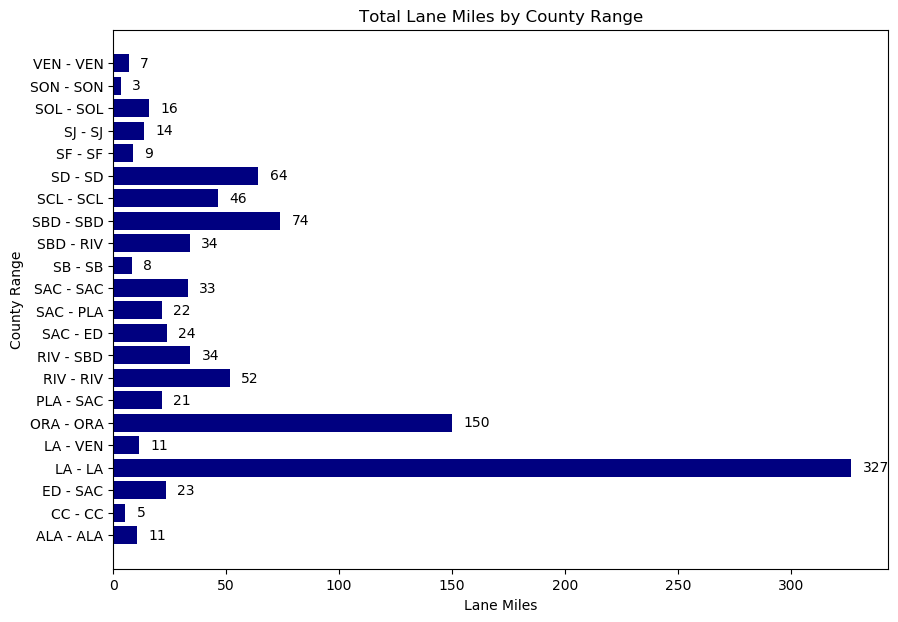

In [23]:
# Group the data by county and sum the lane miles
grouped_data = HOV.groupby(['Begin_County', 'End_County']).agg({'Length__Lane_Miles_': 'sum'}).reset_index()

# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 7))
bars = ax.barh(y=grouped_data['Begin_County'] + ' - ' + grouped_data['End_County'], width=grouped_data['Length__Lane_Miles_'], color='navy')

# Set the axis labels and title
ax.set_xlabel('Lane Miles')
ax.set_ylabel('County Range')
ax.set_title('Total Lane Miles by County Range')

# Add labels to the bars
for i, bar in enumerate(bars):
    value = bar.get_width()
    x_pos = value + 5
    y_pos = i
    ax.text(x_pos, y_pos, str(round(value)), va='center')

# Show the plot
plt.show()

In [25]:
# class imbalance for LA County begin to end
HOV_balanced = grouped_data.apply(
    lambda x: x.sample(grouped_data.size().min())\
    .reset_index(drop=True)
)

TypeError: 'numpy.int64' object is not callable

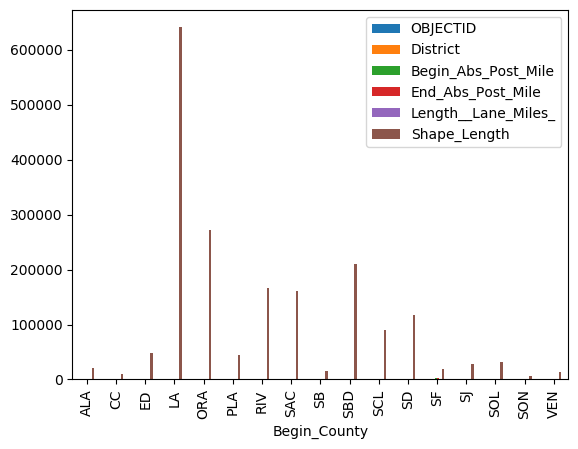

In [33]:
# Group the data by beginning county
HOV_begincounty = HOV.groupby(["Begin_County"]).sum()

HOV_begincounty.plot(kind='bar')

In [34]:
# balancing class imbalance for LA County beginning
HOV_begincounty_grouped = HOV.groupby(["Begin_County"])

HOV_balanced = HOV_begincounty_grouped.apply(
    lambda x: x.sample(HOV_begincounty_grouped.size().min())\
    .reset_index(drop=True)
)

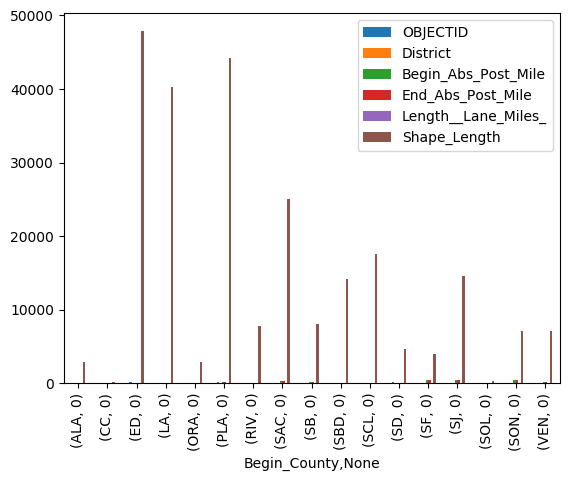

In [38]:
# checking the balance again
HOV_balanced.plot(kind='bar')

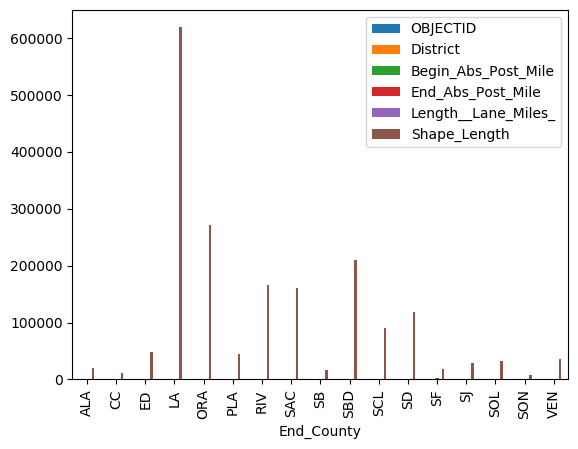

In [39]:
# Group the data by ending county
HOV_endcounty = HOV.groupby(["End_County"]).sum()

HOV_endcounty.plot(kind='bar')

In [40]:
# balancing class imbalance for LA County ending
HOV_endcounty_grouped = HOV.groupby(["End_County"])

HOV_end_balanced = HOV_endcounty_grouped.apply(
    lambda x: x.sample(HOV_endcounty_grouped.size().min())\
    .reset_index(drop=True)
)

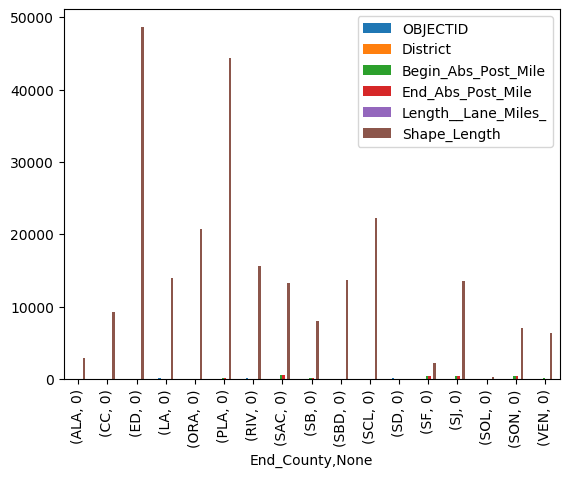

In [41]:
# checking the balance again
HOV_end_balanced.plot(kind='bar')